<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [90]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import hashlib
import math
import shutil
import PIL
import cv2
import pandas as pd
import warnings

from tqdm import tqdm 

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from mpl_toolkits.axes_grid1 import ImageGrid

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [91]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.5.0
Eager mode: True
Found GPU at: /device:GPU:0


In [92]:
def safe_divide(a, b, abs=True):
  val = 0 if type(a) is not np.ndarray else np.zeros(a.shape)

  if b != 0 and not math.isnan(b):
    val = np.divide(a, b)

  return np.int0(val) if abs else val

In [93]:
def resize_image(image, size):
  if len(image.shape) > 2:
    image = image.reshape(size[0], size[1])

  if image.shape[0] != size[0] or image.shape[1] != size[1]:
    width_zoom = size[0] / image.shape[0]
    height_zoom = size[1] / image.shape[1]
    image = sp.ndimage.zoom(image, (height_zoom, width_zoom), order=2)

  return image

In [94]:
def show_image(img, size=None, title=None, ax=None, alpha=1, cmap='Greys', stacked_imgs=[]):
  if size is not None:
    img = resize_image(img, size)
    # img.reshape(size[0], size[1])

  # plot
  subplot = ax is not None

  if not subplot:
    plt.figure(facecolor='white')
    ax = plt.gca()

  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if not subplot:
    plt.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
      s_img = s_image.get('img').reshape(size[0], size[1])
      plt.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

    plt.axis('off')

    if title is not None:
      plt.title(title)
    
    plt.show()
  
  else:
    if title is not None:
      ax.set_title(title, fontdict=None, loc='center', color = "k")
      
    ax.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
        s_img = s_image.get('img').reshape(size[0], size[1])
        ax.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

In [95]:
def show_heatmap(img, cam, size, resize=True, title=None, ax=None):
  heatmap = get_heatmap(cam, size, resize)
  show_image(img, size, title=title, ax=ax, stacked_imgs=[{'img':heatmap, 'cmap':'jet'}])

In [96]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    heatmap = resize_image(heatmap, size)
 
  return heatmap

In [97]:
def show_prediction(image, truth, prediction, label_descriptions=None, size=(28,28)):
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, size, title)

In [98]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [99]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [100]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [101]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [102]:
def get_layer(model, layer_name):
  for layer in model.layers:
    if layer.name == layer_name:
      return layer

  return None

In [103]:
def get_sample(test_set, idx=-1):
  test_idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][test_idx]
  test_label = np.argmax(test_set[1][test_idx])

  return test_image, test_label, test_idx

In [104]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [105]:
def get_prediction(model, test_set, idx=-1):
  x, y, idx = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [106]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [107]:
def copy_model(original_model, trainable=False):
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

In [108]:
def get_boundingbox(image):
  img = np.ones(3, dtype=int)[None, None, :] * (1-image)
  imgray = cv2.cvtColor(img.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return cv2.boundingRect(contours[-1])

In [109]:
def get_grid_position(position, size, boundingbox=None, divisions=(3,3)):
  min_x = 0 if boundingbox is None else boundingbox[0]
  min_y = 0 if boundingbox is None else boundingbox[1]
  max_x = size[0] if boundingbox is None else boundingbox[0] + boundingbox[2]
  max_y = size[1] if boundingbox is None else boundingbox[1] + boundingbox[3]
  x = np.clip(position[0], min_x, max_x) - min_x
  y = np.clip(position[1], min_y, max_y) - min_y

  horizontal_idx =  np.minimum(x / (max_x / divisions[0]), divisions[0]-1)
  vertical_idx =  np.minimum(y / (max_y / divisions[1]), divisions[1]-1)

  # print(f"{vertical_idx}, {horizontal_idx} => {position} - {x}, {y} [{boundingbox}]")
  return np.int0(vertical_idx), np.int0(horizontal_idx)

In [110]:
def get_verbose_grid_position(vertical_idx, horizontal_idx):
  horizontal_labels = ['left', 'mid', 'right']
  vertical_labels = ['top', 'mid', 'bottom']
  
  vertical_idx = np.clip(vertical_idx, 0, len(horizontal_labels)-1)
  horizontal_idx = np.clip(horizontal_idx, 0, len(vertical_labels)-1)

  return vertical_labels[vertical_idx], horizontal_labels[horizontal_idx]

In [111]:
def download_file(name, filepath):
  return tf.keras.utils.get_file(name, filepath)

In [112]:
def load_npz_dataset(path):
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [113]:
def normalize_cam(cam):
  max = np.max(cam)
  min = np.min(cam)
  norm = safe_divide(cam - min, max - min, abs=False)

  return min, max, norm

In [114]:
def show_image_in_grid(image_2d_np_array, image_size, figsize=(16, 16)):
  image_idx = 0
  fig = plt.figure(figsize=figsize)
  grid = ImageGrid(fig, 111, nrows_ncols=image_2d_np_array.shape, axes_pad=0.3, label_mode="1")

  for row in image_2d_np_array:
    for image in row:
      if isinstance(image, dict):
        show_image(image['img'], image_size, ax=grid[image_idx], cmap=image['cmap'], title=image['title'] if 'title' in image else None)
      else:
        show_image(image, image_size, ax=grid[image_idx])
      image_idx += 1

  plt.show()

# CAMs

In [115]:
def cam(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[0][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

In [116]:
def grad_cam_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape:
    conv_output, predictions = cam_model(np.expand_dims(image, 0))
    if len(predictions) > 1:
      predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
    prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
    output = predictions[:, prediction_idx]

  grads = tape.gradient(output, conv_output)
  # print(f"{prediction_idx} -> {hashlib.sha256(grads).hexdigest().upper()}")
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_output = conv_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_output[:, :, i] *= pooled_grads[i]

  cam = np.mean(conv_output, axis=-1)

  return cam, conv_output, predictions, pooled_grads

def grad_cam(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_m(image, cam_model, prediction_idx)

In [117]:
def grad_cam_pp_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = cam_model(np.expand_dims(image, 0))
              if len(predictions) > 1:
                predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, predictions, (conv_first_grad, conv_second_grad, conv_third_grad)

def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_pp_m(image, cam_model, prediction_idx)

#MNIST

In [118]:
mnist_num_classes = 10
mnist_shape = (28, 28)
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="mnist_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="mnist_last_conv"),
          
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="mnist_output"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


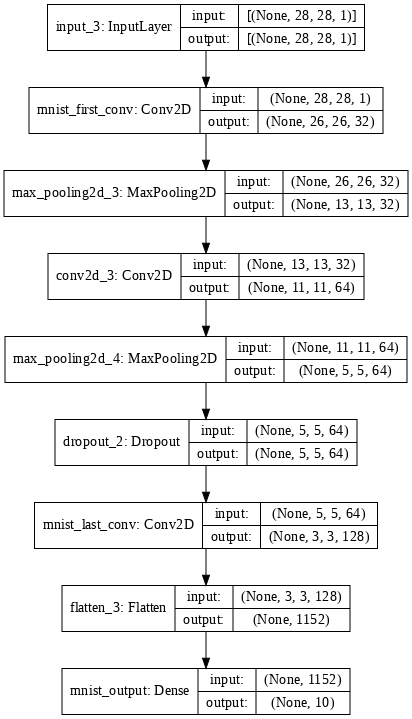

In [119]:
model_mnist = create_mnist_model("gap_shallow", (*mnist_shape, 1), mnist_num_classes, mnist_train)
# model_mnist, history_mnist = load_model("gap_shallow")

display(keras.utils.plot_model(model_mnist, show_shapes=True, dpi=72))

# train
# start_time = time.perf_counter()
# history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
# print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

# evaluate
# score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)
# plot_model_score(score_mnist, history_mnist.history)

#FACE

In [120]:
# https://storage.googleapis.com/public_release/FEC_dataset.zip

fer_dataset = ("fer2013.tar.gz", "https://geo-cam.s3-eu-west-1.amazonaws.com/fer2013.tar.gz", ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
# fer_dataset_path = download_file(fer_dataset[0], fer_dataset[1])
# fer_dataset_explodede_root = f"{fer_dataset[0]}_exploded"
# fer_dataset_explodede_path = f"{fer_dataset_explodede_root}/fer2013/fer2013.csv"

# shutil.unpack_archive(fer_dataset_path, fer_dataset_explodede_root)

In [121]:
# df = pd.read_csv(fer_dataset_explodede_path)
# print(df.shape) 

#GEO

In [122]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset2_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_simple3 = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset3_dataset.npz", ["vertical", "horizontal", "fwd_diagonal", "bck_diagonal", "ellipse", "greather_than", "lower_than", "arrow_up", "arrow_down"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

# dataset
dataset = geo_dataset_simple3
dataset_labels = dataset[2]
dataset_path = download_file(dataset[0], dataset[1])
geo_train, geo_test = load_npz_dataset(dataset_path)
geo_train, geo_test = format_dataset(len(dataset_labels), geo_train, geo_test)

(28, 28)
2
x_train shape: (6300, 28, 28, 1)
6300 train samples
2700 test samples


In [123]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="geo_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.4),
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="geo_last_conv"),
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="geo_output"),
      ]
  )

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

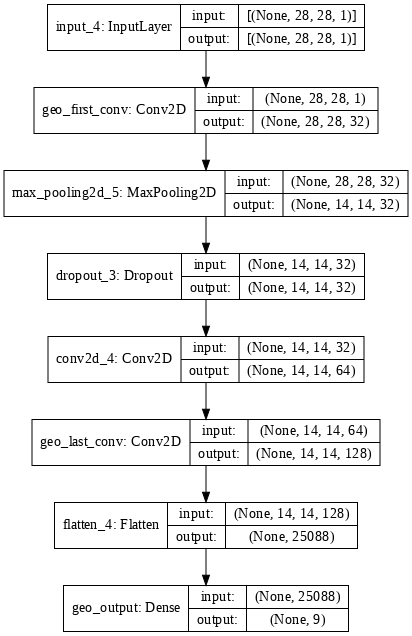

Epoch 1/15
37/37 [==============================] - 1s 24ms/step - loss: 1.5646 - accuracy: 0.4603 - val_loss: 0.8321 - val_accuracy: 0.7562
Epoch 2/15
37/37 [==============================] - 1s 17ms/step - loss: 0.4178 - accuracy: 0.8692 - val_loss: 0.1479 - val_accuracy: 0.9587
Epoch 3/15
37/37 [==============================] - 1s 16ms/step - loss: 0.0963 - accuracy: 0.9706 - val_loss: 0.1054 - val_accuracy: 0.9663
Epoch 4/15
37/37 [==============================] - 1s 17ms/step - loss: 0.0491 - accuracy: 0.9852 - val_loss: 0.0611 - val_accuracy: 0.9835
Epoch 5/15
37/37 [==============================] - 1s 18ms/step - loss: 0.0248 - accuracy: 0.9943 - val_loss: 0.0531 - val_accuracy: 0.9835
Epoch 6/15
37/37 [==============================] - 1s 18ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0263 - val_accuracy: 0.9905
Epoch 7/15
37/37 [==============================] - 1s 16ms/step - loss: 0.0124 - accuracy: 0.9977 - val_loss: 0.0313 - val_accuracy: 0.9886
Epoch 8/15
37

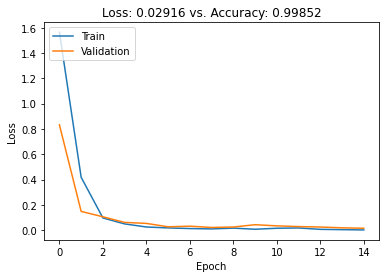

In [124]:
# model
model_geo = create_geo_model("geocam", (*mnist_shape, 1), len(dataset_labels))
# model_geo, history_geo = load_model("geo")

display(keras.utils.plot_model(model_geo, show_shapes=True, dpi=72))

start_time = time.perf_counter()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.25)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_geo, history_geo, "geo")

score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)
plot_model_score(score_geo, history_geo.history)

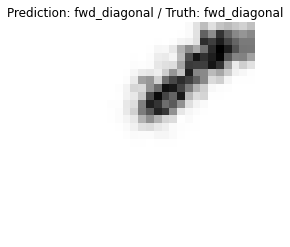

In [125]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset_labels)

# Transfer-learning


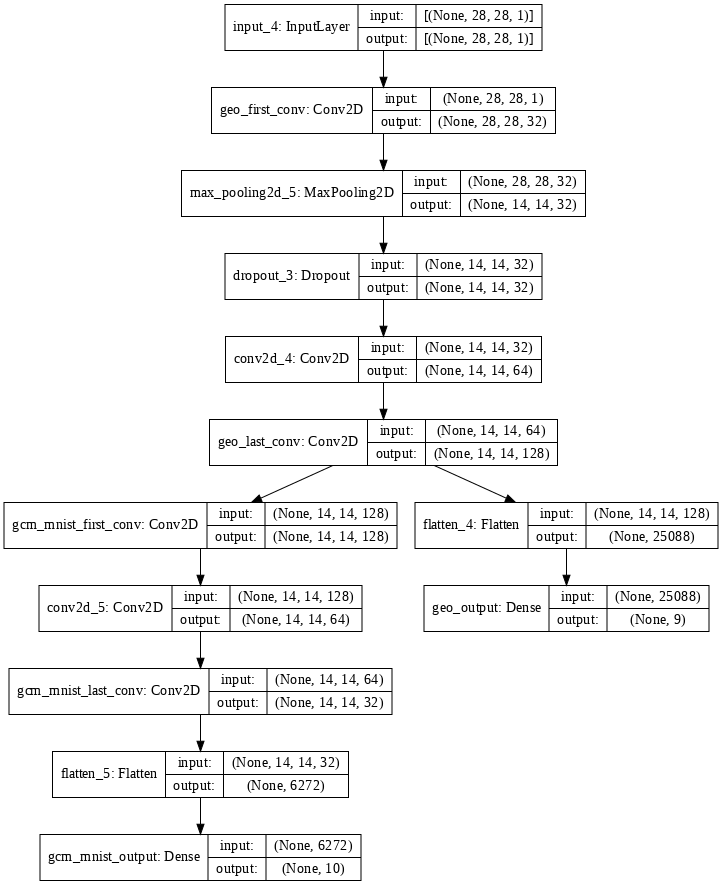

Epoch 1/5
375/375 [==============================] - 8s 21ms/step - loss: 0.2051 - accuracy: 0.9397 - val_loss: 0.0753 - val_accuracy: 0.9765
Epoch 2/5
375/375 [==============================] - 8s 20ms/step - loss: 0.0830 - accuracy: 0.9744 - val_loss: 0.0663 - val_accuracy: 0.9807
Epoch 3/5
375/375 [==============================] - 8s 20ms/step - loss: 0.0714 - accuracy: 0.9785 - val_loss: 0.0692 - val_accuracy: 0.9783
Epoch 4/5
375/375 [==============================] - 8s 20ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0666 - val_accuracy: 0.9803
Epoch 5/5
375/375 [==============================] - 7s 20ms/step - loss: 0.0657 - accuracy: 0.9798 - val_loss: 0.0727 - val_accuracy: 0.9807
Training took: 38.45 seconds


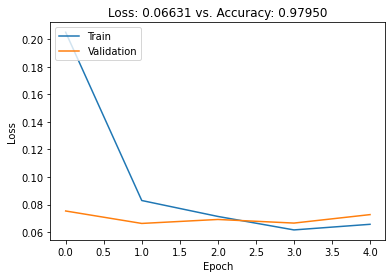

In [126]:
geo_model_copy = copy_model(model_geo, False)
input = geo_model_copy.input
geo_last, geo2_last, last = input, None, None

# utilize a lambda layer to convert the 3 channel input to a grayscale representation
# geo_last = layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input)

# GEO - 1
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  geo_last = layer(geo_last)

# MNIST - 1
last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_first_conv")(geo_last)
mnist_first_cnn = last

last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_last_conv")(last)

# MNIST - 2
last = layers.Flatten()(last)
last = layers.Dense(mnist_num_classes, activation="softmax", name="gcm_mnist_output")(last)

# CONNECTION
# connection = layers.Multiply(name="combination")([geo_last, mnist_first_cnn])
# connection.trainable = False
# mnist_first_cnn.get_output_at(1).set_weights(np.ones(mnist_first_cnn.get_output_at(1).shape))
connection = geo_last

# GEO - 2
for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(connection) if geo2_last is None else layer(geo2_last)

# MODEL
model_gcm = Model(inputs=input, outputs=last)
model_gcm_complete = Model(inputs=input, outputs=[last, geo2_last])

opt = keras.optimizers.Adam(learning_rate=0.004)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# model_gcm_complete.summary()
display(keras.utils.plot_model(model_gcm_complete, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_gcm, history_geocam.history)

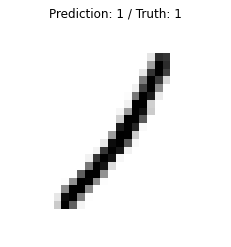

In [127]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# Experiments

In [128]:
test_image, test_label, test_idx = get_sample(mnist_test)

# geo2 (sliced) model (from model_gcm - transfer learning) for cam prediction
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output])

model_gcmcam_1 = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "gcm_mnist_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

model_gcmcam = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "geo_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

cam_threshold = 0.7
cam_method = grad_cam_m

def get_maskedcam_predictions(test_image, classes, cam_method=grad_cam_m, threshold=0.8):  
  centers = dict()
  grid_pos = dict()
  geo_cam = dict()
  masked_geo_cam = dict()
  masked_geo_thresh = dict()

  geo_cam_maxes = []
  masked_geo_cam_maxes = []

  test_image_bb = get_boundingbox(test_image)

  # minist cam mask
  cam, _, mnist_predictions, _ = cam_method(test_image, model_gcmcam_1)
  _, _, cam = normalize_cam(cam)
  mnist_cam = np.copy(cam)

  # geo branch
  for category in range(classes):
    cam = cam_method(test_image, model_geocam, category)[0]
    # print(cam)
    min, max, cam = normalize_cam(cam)

    geo_cam[category] = np.copy(cam)
    geo_cam_maxes.append(max)

  # mask (geo - mnist)
  for category in range(classes):
    modulation = safe_divide(geo_cam_maxes[category], np.max(geo_cam_maxes), abs=False) # modulation
    cam = geo_cam[category] - (geo_cam[category] * (1 - mnist_cam)) # mask
    # cam = cam * modulation
    # print(f"min: {np.min(cam)}, max: {np.max(cam)}")
    masked_geo_cam_maxes.append(np.max(cam) * modulation)
    masked_geo_cam[category] = np.copy(cam)

  # threshorld and centers
  for category in range(classes):
    cam = masked_geo_cam[category]
    # cam = (cam >= threshold) * threshold
    cam = resize_image(cam, mnist_shape)

    _, cam = cv2.threshold(cam, np.max(cam) * threshold, np.max(cam), cv2.THRESH_BINARY)
    
    masked_geo_thresh[category] = cam

    cv_img = np.array(cam * 255, dtype = np.uint8)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    centers[category] = []
    grid_pos[category] = set()

    for i in range(len(contours)):
      moments = cv2.moments(contours[i])
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        grid_position = get_grid_position(center, mnist_shape, boundingbox=test_image_bb)
        
        centers[category].append(center)
        grid_pos[category].add(grid_position)
  
  extra_infos = dict()
  extra_infos['order'] = np.flip(np.argsort(masked_geo_cam_maxes), 0)
  extra_infos['maxes'] = masked_geo_cam_maxes
  extra_infos['thresholds'] = masked_geo_thresh
  extra_infos['geo_cams'] = geo_cam
  extra_infos['mnist_cam'] = mnist_cam
  extra_infos['mnist_pred'] = np.argmax(mnist_predictions)
  extra_infos['centers'] = centers
  extra_infos['grid_pos'] = grid_pos

  return masked_geo_cam, extra_infos

# cam, extras = get_maskedcam_predictions(test_image, len(dataset_labels))

# first_pred = extras['order'][0]

# print(f"first: {dataset_labels[first_pred]} - total order: {extras['order']}")
# print(extras['grid_pos'][first_pred])

# show_image_in_grid(np.array([
#                              [
#                               test_image, 
#                               {'img': extras['geo_cams'][first_pred], 'cmap':'jet', 'title':'geo'},
#                               {'img': extras['mnist_cam'], 'cmap':'jet', 'title':'mnist'},
#                               {'img': cam[first_pred], 'cmap':'jet', 'title':'geo-cam'},
#                               extras['thresholds'][first_pred],
#                               ]
#                              ]), mnist_shape)

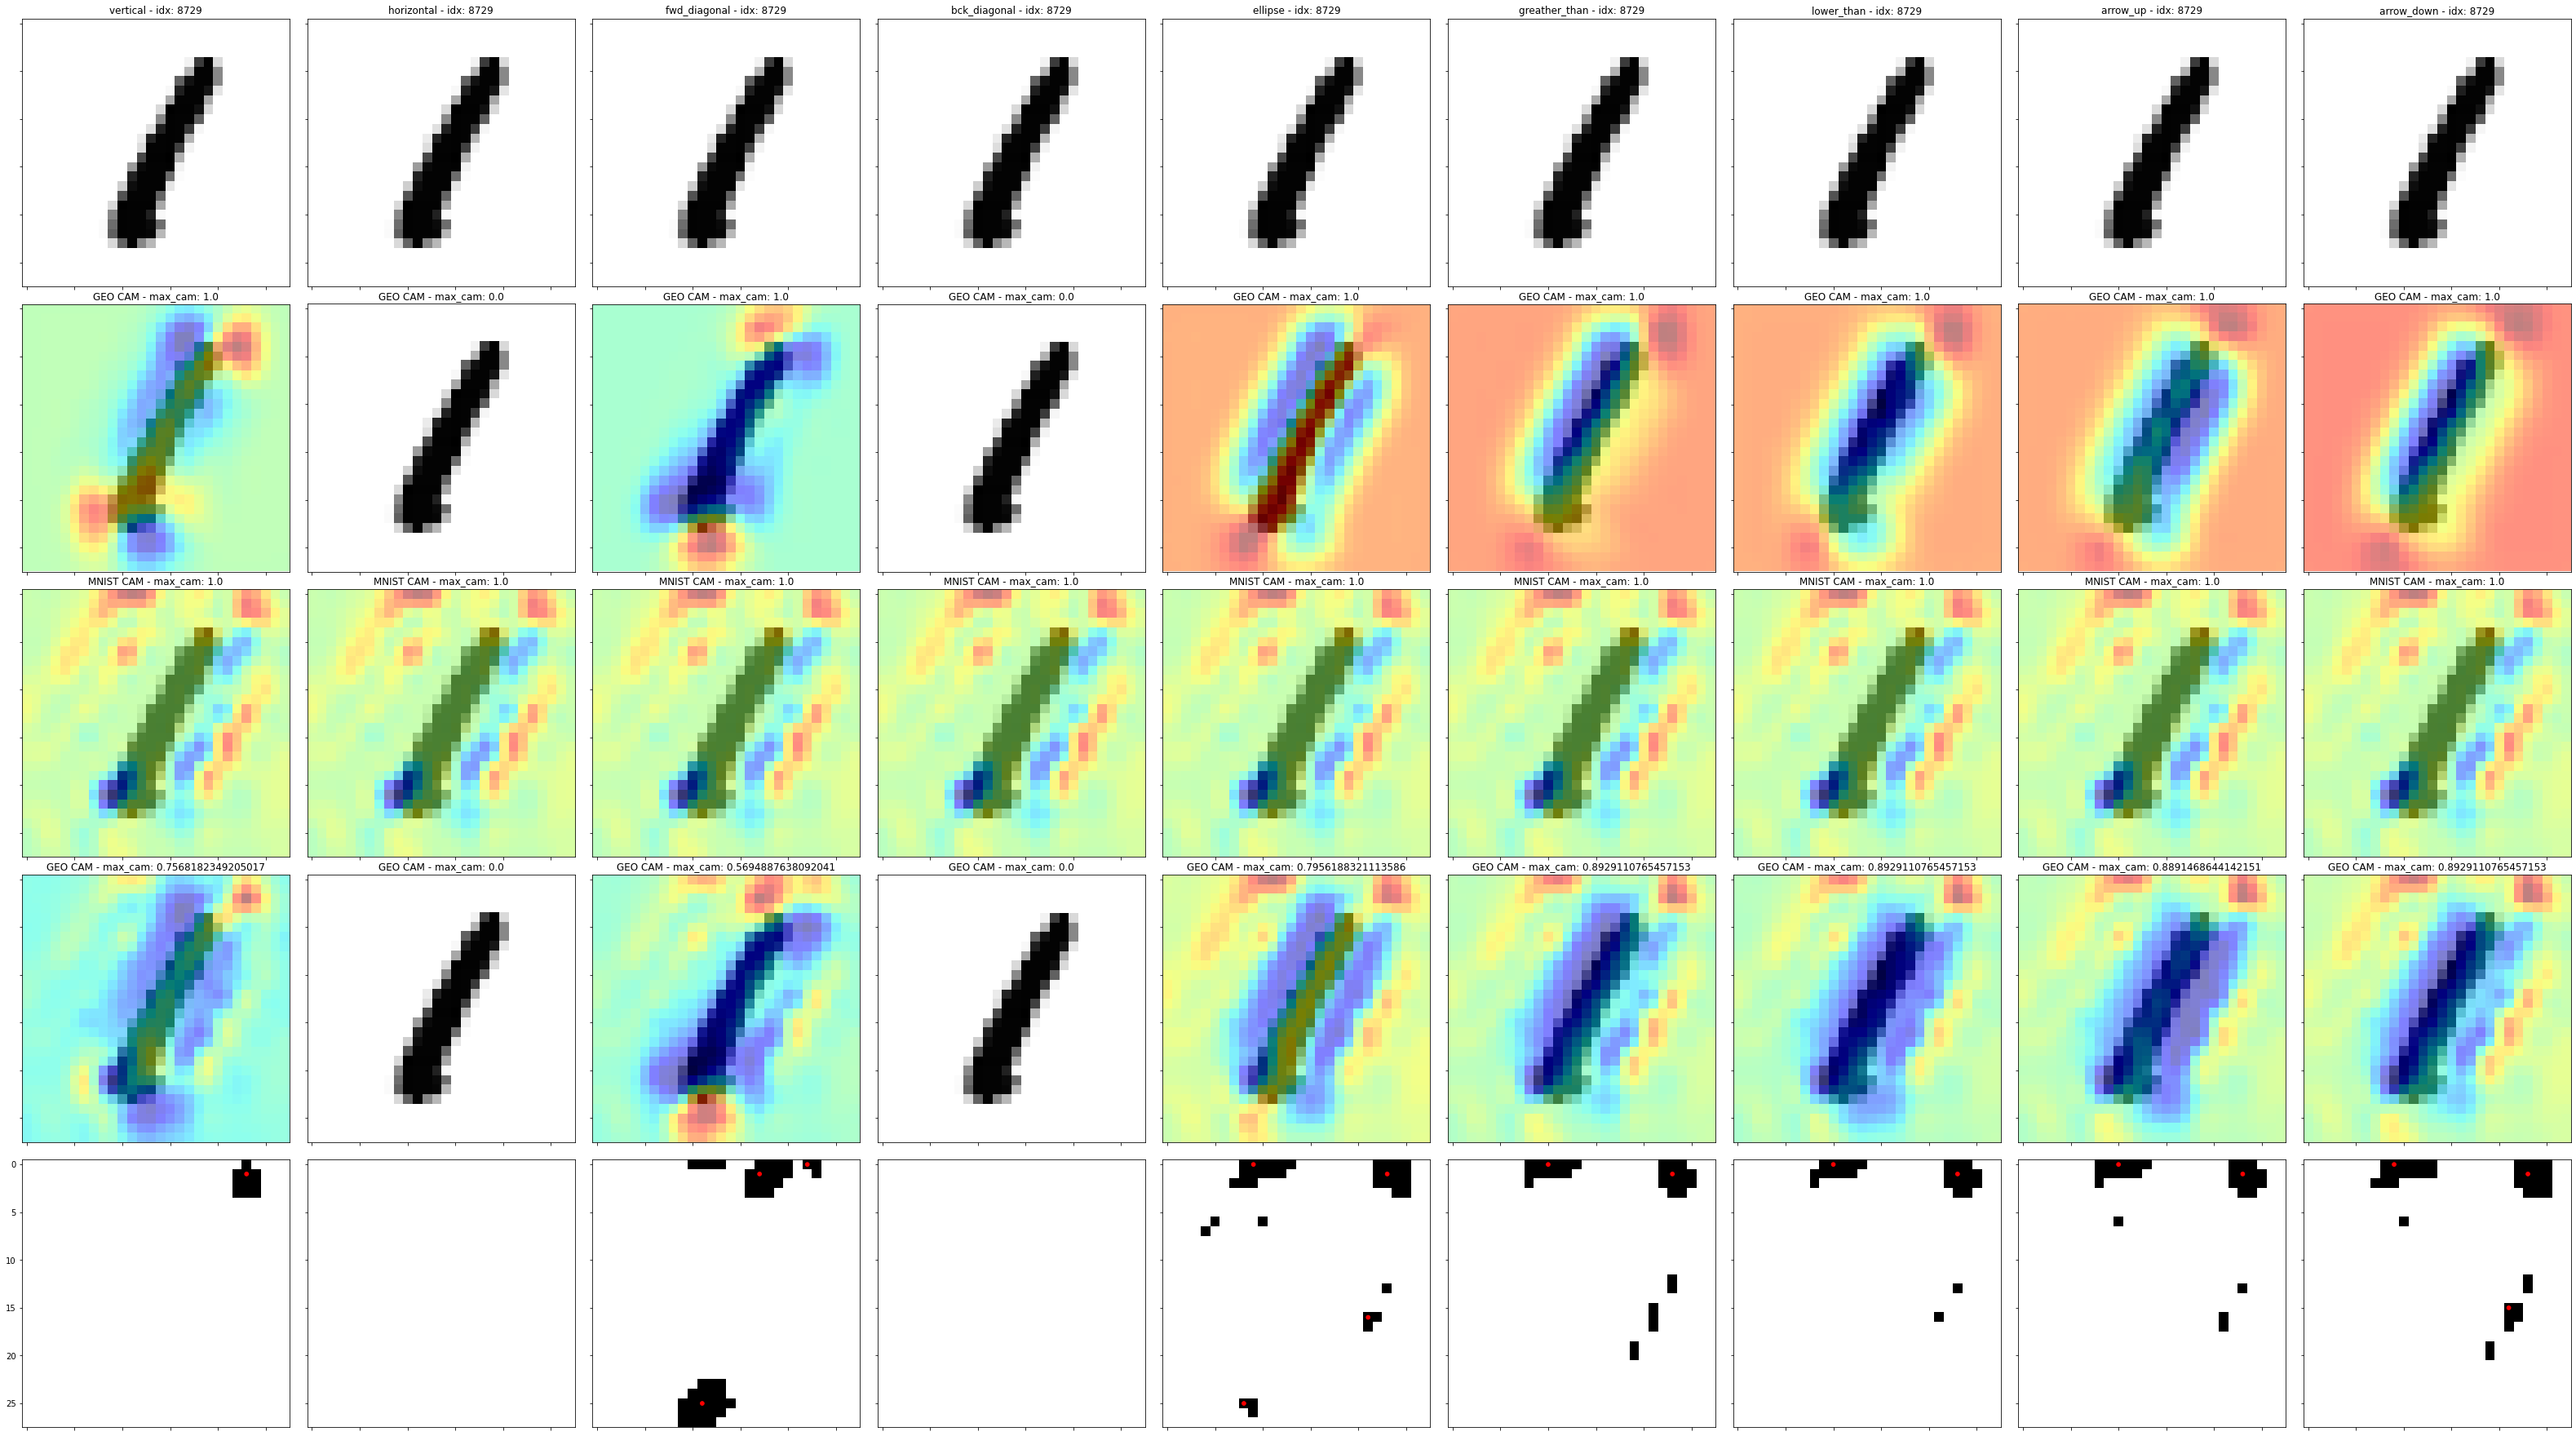

In [129]:
warnings.simplefilter('ignore', UserWarning)

# prediction based on conv output (5056, 6146, 2365, 2587, 5310, 6638, 1195)
test_image, test_label, test_idx = get_sample(mnist_test)
mnist_gcm_predictions = predict(model_gcm, test_image)
mnist_gcm_prediction = np.argmax(mnist_gcm_predictions)

assert test_label == mnist_gcm_prediction, "Missmatched ids. Wanted %d, received %d" % (test_label, mnist_gcm_prediction)

# start plotting
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(5, len(dataset_labels)), axes_pad=0.3, label_mode="1")

# images
for category in range(len(dataset_labels)):
  title = f"{dataset_labels[category]} - idx: {test_idx}"
  show_image(test_image, mnist_shape, title, ax=grid[image_idx])
  image_idx += 1

# geocam
cam_activations, cam_extra = get_maskedcam_predictions(test_image, len(dataset_labels), cam_method=cam_method, threshold=cam_threshold)

# geo cam
for category in range(len(dataset_labels)):
  cam = cam_extra['geo_cams'][category]
  title = f"GEO CAM - max_cam: {np.max(cam)}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# minist cam
cam = cam_extra['mnist_cam']
for category in range(len(dataset_labels)):
  title = f"MNIST CAM - max_cam: {np.max(cam)}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# geocam cam
for category in range(len(dataset_labels)):
  cam = cam_activations[category]
  title = f"GEO CAM - max_cam: {np.max(cam)}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# geocam areas
for category in range(len(dataset_labels)):
  camt = cam_extra['thresholds'][category]
  grid[image_idx].imshow(camt, cmap='Greys')

  camp = cam_extra['centers'][category]
  for center_idx in range(len(camp)):
    camp_center = camp[center_idx]
    grid[image_idx].add_patch(plt.Circle(camp_center, 0.2, color='r'))

  image_idx += 1

plt.show()

total order: [4 2 6 8 5 0 7 3 1]


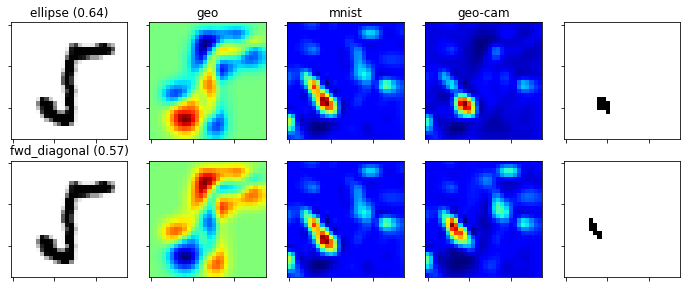

The number 5 can be explained by having a(n) ellipse on the mid-left and a(n) fwd_diagonal on the mid-left.


In [130]:
test_image, test_label, test_idx = get_sample(mnist_test)

cam, extras = get_maskedcam_predictions(test_image, len(dataset_labels), threshold=0.7)

first_pred = extras['order'][0]
sec_pred = extras['order'][1]

print(f"total order: {extras['order']}")

show_image_in_grid(np.array([
                             [
                              {'img': test_image, 'cmap':'Greys', 'title':f"{dataset_labels[first_pred]} ({extras['maxes'][first_pred]:.2f})"},
                              {'img': extras['geo_cams'][first_pred], 'cmap':'jet', 'title':'geo'},
                              {'img': extras['mnist_cam'], 'cmap':'jet', 'title':'mnist'},
                              {'img': cam[first_pred], 'cmap':'jet', 'title':'geo-cam'},
                              extras['thresholds'][first_pred],
                              ],
                             [
                              {'img': test_image, 'cmap':'Greys', 'title':f"{dataset_labels[sec_pred]} ({extras['maxes'][sec_pred]:.2f})"},
                              {'img': extras['geo_cams'][sec_pred], 'cmap':'jet'},
                              {'img': extras['mnist_cam'], 'cmap':'jet'},
                              {'img': cam[sec_pred], 'cmap':'jet'},
                              extras['thresholds'][sec_pred],
                              ]
                             ]), mnist_shape, figsize=(12, 12))

explanation = ""

for idx in range(2):
  order = extras['order'][idx]
  verbose_key = dataset_labels[order]

  grid_positions = extras['grid_pos'][idx]

  if len(grid_positions) > 0:
    if len(explanation) > 0:
      explanation += " and"
    explanation += f" a(n) {verbose_key} on the"

  for grid_position in grid_positions:
    verbose_grid_pos = get_verbose_grid_position(*grid_position)
    explanation += f" {verbose_grid_pos[0]}-{verbose_grid_pos[1]}"

print(f"The number {extras['mnist_pred']} can be explained by having{explanation}.")

In [131]:
samples = 100
descriptions = dict()

with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for mnist_category in range(mnist_num_classes):
      descriptions[mnist_category] = dict()
      decomposed_category = np.zeros(shape=(mnist_num_classes))
      decomposed_category[mnist_category] = 1

      for geo_class in range(len(dataset_labels)):
          descriptions[mnist_category][geo_class] = []

      for i in range(samples):
        validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
        test_image = mnist_test[0][validation_idx]
        test_image_bb = get_boundingbox(test_image)

        # geo cam
        cam, extras = get_maskedcam_predictions(test_image, len(dataset_labels), cam_method=cam_method, threshold=cam_threshold)

        for i in range(2):
          geo_category_key = extras['order'][i]

          for grid_position in extras['grid_pos'][geo_category_key]:
            descriptions[mnist_category][geo_category_key].append(grid_position)

        pbar.update()

100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]


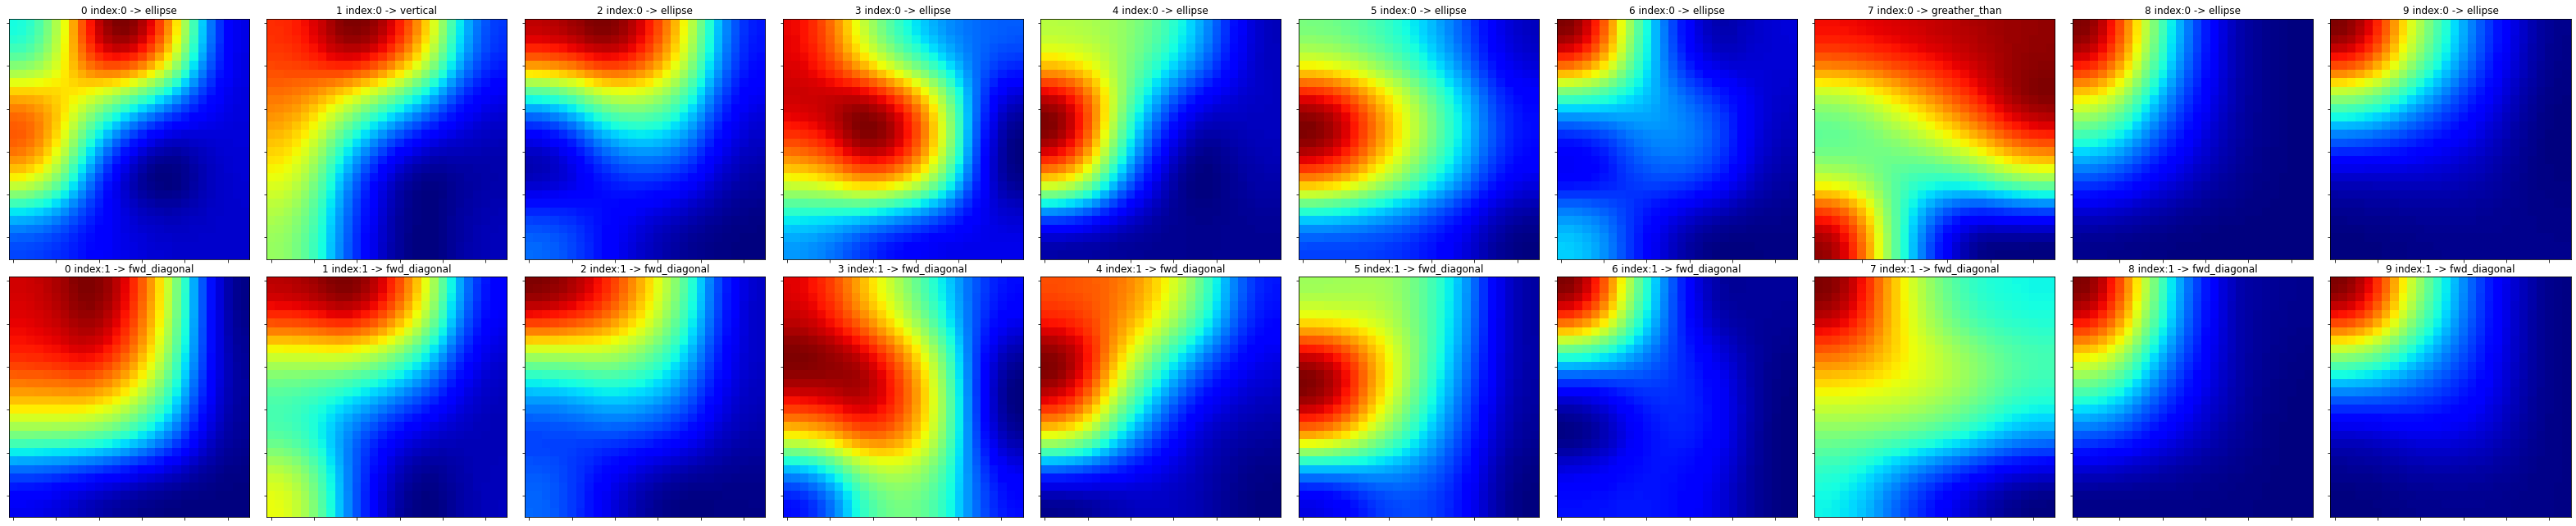

In [132]:
# heightmap
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(2, mnist_num_classes), axes_pad=0.3, label_mode="1", direction='column')

for category in range(mnist_num_classes):
  heightmap = np.zeros((3, 3))
  geo_category = descriptions[category]
  index = 0
  
  for geo_cat in sorted(geo_category, key=lambda k: len(geo_category[k]), reverse=True):
    title = f"{category} index:{index} -> {dataset_labels[geo_cat]}"

    for grid_position in geo_category[geo_cat]:
      heightmap[grid_position] += 1
    
    heigthmap = get_heatmap(heightmap, mnist_shape, True)
    show_image(heigthmap, mnist_shape, title, ax=grid[image_idx], cmap='jet')
    image_idx += 1

    if index < 1: 
      index += 1
    else:
      break

plt.show()

In [133]:
print("DESCRIPTIONS:")

for category in range(mnist_num_classes):
  print(f"\n{category}")

  for description_position in descriptions[category]:
    verbose_positions = set()
    grid_position = descriptions[category][description_position]
    aggregated_amount = len(grid_position)
    
    for k in grid_position:
      verbose_positions.add(get_verbose_grid_position(*k))
    
    print(f"└ {description_position}: {aggregated_amount} = {verbose_positions}")

DESCRIPTIONS:

0
└ 0: 10 = {('top', 'mid'), ('top', 'left')}
└ 1: 10 = {('top', 'mid'), ('top', 'left'), ('mid', 'left')}
└ 2: 172 = {('top', 'mid'), ('mid', 'mid'), ('mid', 'right'), ('bottom', 'mid'), ('bottom', 'right'), ('bottom', 'left'), ('top', 'left'), ('mid', 'left')}
└ 3: 2 = {('top', 'mid'), ('mid', 'left')}
└ 4: 199 = {('top', 'mid'), ('mid', 'mid'), ('mid', 'right'), ('top', 'right'), ('bottom', 'mid'), ('bottom', 'left'), ('top', 'left'), ('mid', 'left')}
└ 5: 2 = {('top', 'mid'), ('mid', 'left')}
└ 6: 15 = {('top', 'mid'), ('top', 'left'), ('bottom', 'left'), ('mid', 'left')}
└ 7: 0 = set()
└ 8: 0 = set()

1
└ 0: 124 = {('top', 'mid'), ('mid', 'mid'), ('top', 'right'), ('bottom', 'left'), ('top', 'left'), ('mid', 'left')}
└ 1: 0 = set()
└ 2: 120 = {('top', 'mid'), ('mid', 'mid'), ('bottom', 'mid'), ('bottom', 'left'), ('top', 'left'), ('mid', 'left')}
└ 3: 4 = {('top', 'mid'), ('top', 'left'), ('mid', 'mid'), ('bottom', 'left')}
└ 4: 8 = {('mid', 'mid'), ('top', 'right')

# Metrics

In [136]:
digits_descriptions = [
  ["ellipse"], #0
  ["vertical", "fwd_diagonal"], #1
  ["horizontal", "fwd_diagonal", "ellipse"], #2
  ["greather_than", "lower_than", "ellipse"], #3
  ["vertical", "horizontal"], #4
  ["greather_than", "ellipse", "vertical", "horizontal"], #5
  ["fwd_diagonal", "vertical", "ellipse"], #6
  ["fwd_diagonal", "vertical", "horizontal"], #7
  ["ellipse"], #8
  ["ellipse", "fwd_diagonal", "vertical"], #9
]

samples = 100
metrics, y_true, y_pred = dict(), dict(), dict()

with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for mnist_category in range(mnist_num_classes):
    metrics[mnist_category] = dict()
    
    decomposed_category = np.zeros(shape=(mnist_num_classes))
    decomposed_category[mnist_category] = 1
    
    y_true[mnist_category] = np.ones(shape=(samples))
    y_pred[mnist_category] = np.zeros(shape=(samples))

    for i in range(samples):
      validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
      test_image = mnist_test[0][validation_idx]

      # geo cam
      cam, extras = get_maskedcam_predictions(test_image, len(dataset_labels), cam_method=cam_method, threshold=cam_threshold)

      # prediction
      y_pred[mnist_category][i] = int(dataset_labels[extras['order'][0]] in digits_descriptions[mnist_category] or
                                      dataset_labels[extras['order'][1]] in digits_descriptions[mnist_category])

      pbar.update()

    # metrics per category
    metrics[mnist_category]['accuracy']   = accuracy_score(y_true[mnist_category], y_pred[mnist_category])
    metrics[mnist_category]['precision']  = precision_score(y_true[mnist_category], y_pred[mnist_category], average='weighted', zero_division=0)
    metrics[mnist_category]['recall']     = recall_score(y_true[mnist_category], y_pred[mnist_category], average='weighted', zero_division=0)
    metrics[mnist_category]['f1']         = f1_score(y_true[mnist_category], y_pred[mnist_category], average='weighted', zero_division=0)

# out
print("\n\nMETRICS:")

# macro metrics
print("\nMacro:")
macro_metrics = dict()
for cat in metrics:
  for key in metrics[cat]:
    macro_metrics[key] = macro_metrics.get(key) or []
    macro_metrics[key].append(metrics[cat][key])
  
for key in macro_metrics:
  print(f"- {key}: {np.average(macro_metrics[key]):.2f}")

# micro metrics
print("\nMicro:")
for cat in metrics:
  all_metrics = ', '.join([f"{key}:{np.average(metrics[cat][key]):.2f}" for key in metrics[cat]])
  print(f"- {cat}: {all_metrics}")

100%|██████████| 1000/1000 [01:33<00:00, 10.68it/s]



METRICS:

Macro:
- accuracy: 0.91
- precision: 1.00
- recall: 0.91
- f1: 0.94

Micro:
- 0: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 1: accuracy:0.96, precision:1.00, recall:0.96, f1:0.98
- 2: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 3: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 4: accuracy:0.29, precision:1.00, recall:0.29, f1:0.45
- 5: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 6: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 7: accuracy:0.89, precision:1.00, recall:0.89, f1:0.94
- 8: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 9: accuracy:0.99, precision:1.00, recall:0.99, f1:0.99


# Archive

In [135]:
raise Exception('do not run any further')

Exception: ignored

In [ ]:
def get_cam_predictions(test_image, model, classes, cam_method=grad_cam_m, threshold=180):
  cam_predictions = dict()
  cam_activations = dict()
  cam_thresholds = dict()
  min_cam_activation, max_cam_activation = 0, 0

  for category in range(classes):
    cam, _, _, _ = cam_method(test_image, model, category, 1)
    cam_activations[category] = cam
    min, max = np.min(cam), np.max(cam)
    min_cam_activation = np.minimum(min, min_cam_activation)
    max_cam_activation = np.maximum(max, max_cam_activation)

  for category in range(classes):
    cam = cam_activations[category]
    perc = safe_divide(cam - min_cam_activation, max_cam_activation - min_cam_activation, abs=False)
    
    cam = resize_image(perc, mnist_shape) * 255
    _, cam = cv2.threshold(cam, threshold, 255, cv2.THRESH_BINARY)
    cam_thresholds[category] = cam
    cv_img = np.array(cam, dtype = np.uint8)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cam_predictions[category] = (np.max(perc), [])

    for i in range(len(contours)):
      moments = cv2.moments(contours[i])
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        cam_predictions[category][1].append(center)
  
  return cam_activations, cam_thresholds, cam_predictions

In [ ]:
# Predictions
_, predictions = model_gcmcam(np.expand_dims(test_image, 0))
sorted_indexes = np.flip(np.argsort(predictions[1][0]))
percentages = np.round(predictions[1][0] / predictions[1][0][sorted_indexes[0]], 5)

print(f"1st : {dataset_labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset_labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset_labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

In [ ]:
# verifying transfer learning
print(f"geo conv weights: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm1 conv weights: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm2 conv weights: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")

print(f"geo conv biases: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm1 conv biases: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm2 conv biases: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")

test_image, test_label, test_idx = get_sample(mnist_test)
test_geo = Model([model_geo.inputs], [get_layer(model_geo, 'geo_last_conv').get_output_at(0), model_geo.output])
test_gcm = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'geo_last_conv').get_output_at(1), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])
test_gcm_ = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'gcm_mnist_first_conv').get_output_at(0), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])

print(f"geo conv activations: {hashlib.sha256(test_geo(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm conv activations: {hashlib.sha256(test_gcm(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm alterate conv activations: {hashlib.sha256(test_gcm_(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")

In [ ]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")

title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, mnist_shape, True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

In [ ]:
# 1) prediction based on conv output
test_image, test_label = get_sample(mnist_test)

cam_layer = get_cam_layer(model_gcm, "conv2d_5")
cam_model = Model([model_gcm.inputs], [cam_layer.get_output_at(1), model_gcm.output])
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp_m(test_image, cam_model)
# print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# Prediction
gcg_predictions = model_geo_2.predict(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {dataset_labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset_labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset_labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, sorted_indexes[0])
show_heatmap(test_image, gcg_mnist_cam, mnist_shape, True)

In [ ]:
# 2) prediction based on cam heatmap (SHOULD NOT WORK)

test_image, test_label = get_sample(mnist_test, 6187)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, mnist_shape).reshape(*mnist_shape, 1) * 255
prediction = predict(model_geo, heatmap)

show_image(heatmap)

sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {dataset_labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset_labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset_labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(*mnist_shape), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(*mnist_shape), cmap='jet', alpha=0.5)
plt.show()  